In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
pip install wordcloud


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud


In [7]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils


### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [8]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [41]:
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import os
import pandas as pd
import glob
from src.loader import SlackDataLoader, slack_parser, parse_slack_reaction
from src.utils import get_messages_dict

# Provide the path to the Slack exported data folder
slack_data_path = os.path.abspath('../anonymized')

# Create an instance of SlackDataLoader
slack_data_loader = SlackDataLoader(slack_data_path)

# Get the users and channels from the Slack data
users = slack_data_loader.get_users()
channels = slack_data_loader.get_channels()
channel_names = []
user_names = []

for channel in channels:
    channel_names.append(channel['name'])

for user in users:
    user_names.append(user['name'])

# print(channel_names)


In [73]:
parsed = slack_parser('../anonymized/all-community-building/')

parsed['channel']

0       all-community-building
1       all-community-building
2       all-community-building
3       all-community-building
4       all-community-building
                 ...          
7608    all-community-building
7609    all-community-building
7610    all-community-building
7611    all-community-building
7612    all-community-building
Name: channel, Length: 7613, dtype: object

In [74]:
def create_combined_dataframe(channel_names):
    data_frames = []
    ROOT_DIR = '../anonymized/'

    for channel in channel_names:
        channel_path = ROOT_DIR + channel +  '/'
        channel_dataframe = slack_parser(channel_path)
        data_frames.append(channel_dataframe)
        

    combined_data = pd.concat(data_frames, ignore_index=True)

    return combined_data

combined_data = create_combined_dataframe(channel_names)  

combined_data

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,morning boss,Gregory Bowman,1666940798.397899,text,0,0,0,0,0,all-community-building
1,message,you can find the updated list of the hot seate...,Gregory Bowman,1666948195.284989,text,0,0,0,0,0,all-community-building
2,message,*community building session reminder!*:timer_c...,Lynn Shepherd,1666957800.615229,text,0,0,0,0,0,all-community-building
3,message,hello,David Nguyen,1666958458.036999,text,0,0,0,0,0,all-community-building
4,message,selam,Glenn Richardson,1666958469.370489,text,0,0,0,0,0,all-community-building
...,...,...,...,...,...,...,...,...,...,...,...
17744,message,<https://www.linkedin.com/feed/update/urn:li:a...,David Nguyen,1668091209.246809,link,0,0,0,0,0,all-week12
17745,message,isn't that a connection problem?,Tammy Foster,1668092676.858439,text,1668090991.470289,0,0,0,0,all-week12
17746,message,my connection work properly <@u03ujgp0c68>,Lisa Dickerson,1668100415.828559,text,1668090991.470289,0,0,0,0,all-week12
17747,message,<https://developer.algorand.org/solutions/mint...,Dennis Parker,1668359175.400459,link,0,0,0,0,0,all-web3-week12


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [80]:
def get_top_10_users_by_reply(df):
     # Get value counts of 'sender_id' column
    user_reply_counts = df['sender_name'].value_counts()

    # Get the top 10 users by reply count
    top_10_users = user_reply_counts.head(10)

    return top_10_users

def get_bottom_10_users_by_reply(df):
    # Get value counts of 'sender_id' column
    user_reply_counts = df['sender_name'].value_counts()

    # Get the bottom 10 users by reply count
    bottom_10_users = user_reply_counts.tail(10)

    return bottom_10_users

In [81]:
get_top_10_users_by_reply(combined_data)

Lynn Shepherd        1288
Kelsey Shields       1150
Gregory Bowman       1075
Zachary Clark         991
Monica Newton         843
Lisa Dickerson        831
Ariel Lopez           754
James Mann            641
Tammy Foster          574
Jennifer Carrillo     519
Name: sender_name, dtype: int64

In [82]:
get_bottom_10_users_by_reply(combined_data)

John Richard           10
Luis Smith              8
Jonathan Jenkins        7
Frances Carpenter       5
Slackbot                3
Nicole Medina           1
Austin Franco           1
Mary Allen              1
Veronica Richardson     1
Allen Mccarthy          1
Name: sender_name, dtype: int64

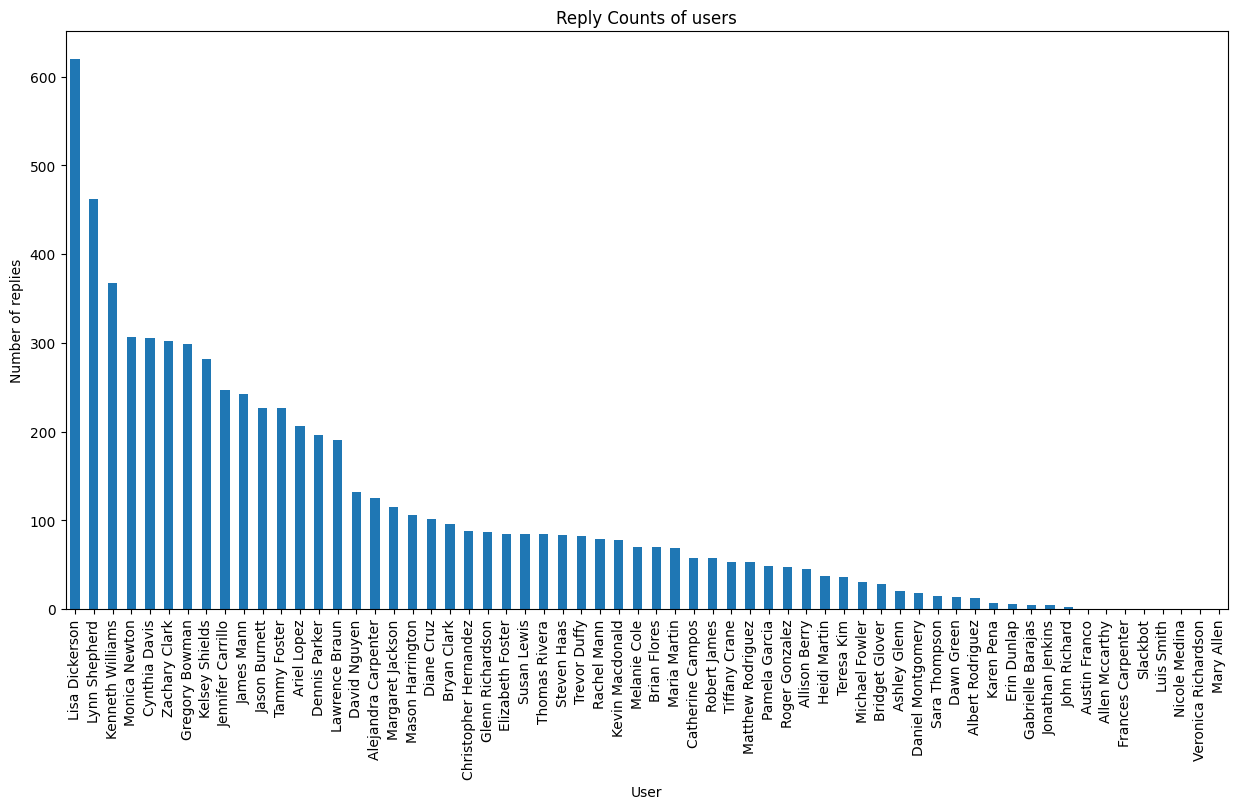

In [75]:
#plot of highest number of reply counts per user
def plot_highest_replies_per_user(data):
    grouped_df = data.groupby('sender_name')['reply_count'].sum()
    grouped_df = grouped_df.sort_values(ascending=False)
    grouped_df.plot(kind='bar', figsize=(15, 7.5))
    
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of replies')
    plt.show()

plot_highest_replies_per_user(combined_data)

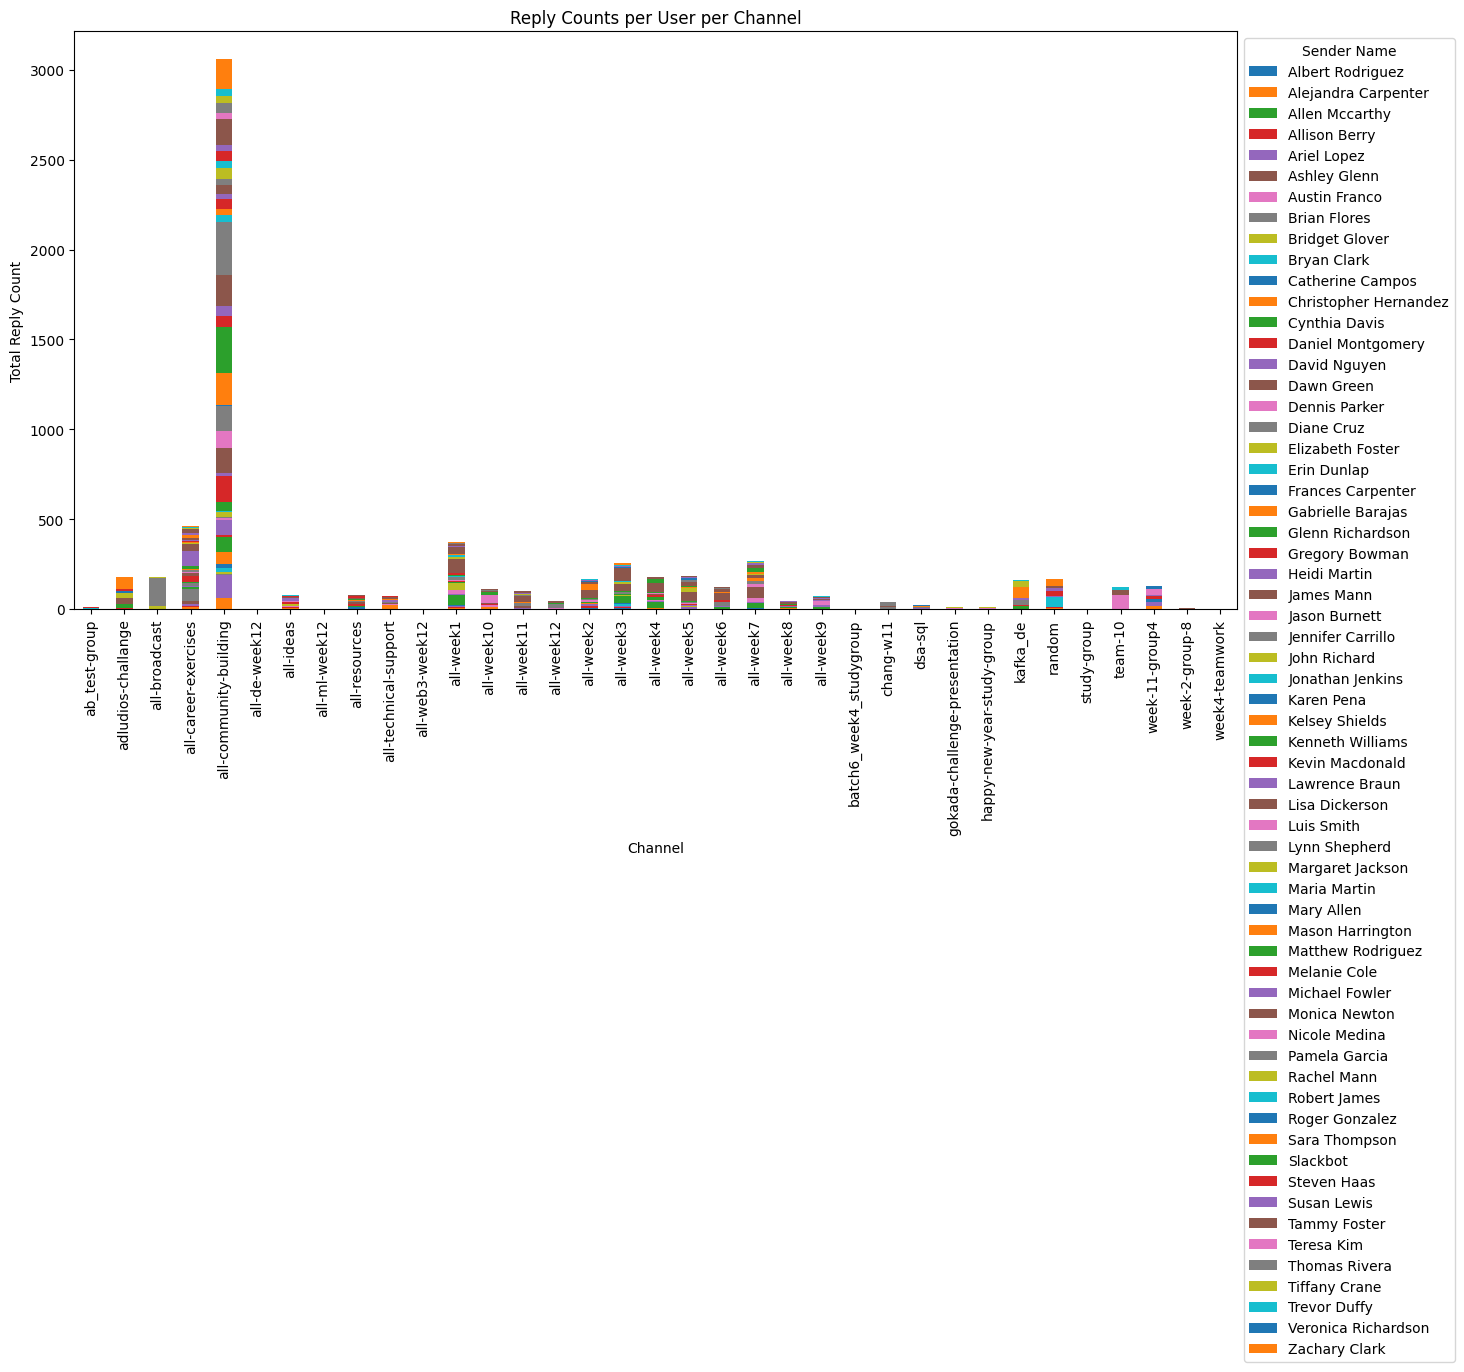

In [76]:
# Visualize reply counts per user per channel
def reply_per_user_per_channel(data):
    grouped_df = data.groupby(['channel', 'sender_name'])['reply_count'].sum().unstack()
    grouped_df.plot(kind='bar', figsize=(15, 7.5), stacked=True)
    
    plt.title('Reply Counts per User per Channel')
    plt.xlabel('Channel')
    plt.ylabel('Total Reply Count')
    plt.legend(title='Sender Name', bbox_to_anchor=(1, 1))
    plt.show()

    
reply_per_user_per_channel(combined_data)

In [26]:
# which user has the highest number of reply counts?

In [28]:
# Visualize reply counts per user per channel

In [30]:
# what is the time range of the day that most messages are sent?


In [29]:
# what kind of messages are replied faster than others?

In [31]:
# Relationship between # of messages and # of reactions

In [32]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [33]:
# Which users got the most reactions?

In [34]:
# Model topics mentioned in the channel

In [35]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [36]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?